In [ ]:
# we should try with both the edinburgh set: https://datashare.is.ed.ac.uk/handle/10283/2791  (they use artificial noise http://homepages.inf.ed.ac.uk/cvbotinh/se/noises/)
# and some other clean data which we artificially make noisy using https://pypi.org/project/audiomentations/
# ideally we find something hosted on GCloud because its quicker to `!gs -cp src dest` to colab

In [1]:
pip install librosa==0.6

     |████████████████████████████████| 1.5MB 6.0MB/s 
  Created wheel for librosa: filename=librosa-0.6.0-cp36-none-any.whl size=1553495 sha256=24a772bc8e703af8c6dd3b3aaed109fbbae4238d807cd794270b7747b8847c76
  Stored in directory: /root/.cache/pip/wheels/0d/19/fa/71097e2207df1cc613749f15b2f0b1972c167b36d6afc09d15
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3


In [2]:
import numpy as np
from IPython.display import Audio
from scipy.io import wavfile
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend 
import tensorflow as tf
import os
print(tf.__version__)
import librosa

from scipy import stats

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


2.3.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def unet(pretrained_weights = None,input_size = (128,128,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(16, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)


    conv2 = Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)


    conv3 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)


    conv4 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(128, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = LeakyReLU()(conv6)

    up7 = Conv2D(64, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = LeakyReLU()(conv7)

    up8 = Conv2D(32, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(16, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(16, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mae'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [36]:
def create_data(noise_dir, voice_dir, path_save_time_serie, path_save_sound, path_save_spectrogram, sample_rate,
min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft):
    """This function will randomly blend some clean voices from voice_dir with some noises from noise_dir
    and save the spectrograms of noisy voice, noise and clean voices to disk as well as complex phase,
    time series and sounds. This aims at preparing datasets for denoising training. It takes as inputs
    parameters defined in args module"""
    
    
    print("A")
    list_noise_files = os.listdir(noise_dir)
    list_voice_files = os.listdir(voice_dir)

    def remove_ds_store(lst):
        """remove mac specific file if present"""
        if '.DS_Store' in lst:
            lst.remove('.DS_Store')

        return lst

    list_noise_files = remove_ds_store(list_noise_files)
    list_voice_files = remove_ds_store(list_voice_files)

    nb_voice_files = len(list_voice_files)
    nb_noise_files = len(list_noise_files)


    # Extracting noise and voice from folder and convert to numpy
    noise = audio_files_to_numpy(noise_dir, list_noise_files, sample_rate,
                                     frame_length, hop_length_frame_noise, min_duration)
    
    print("Extract Noise")

    voice = audio_files_to_numpy(voice_dir, list_voice_files,
                                     sample_rate, frame_length, hop_length_frame, min_duration)
    
    print("Extract Voice")

    # Blend some clean voices with random selected noises (and a random level of noise)
    prod_voice, prod_noise, prod_noisy_voice = blend_noise_randomly(
            voice, noise, nb_samples, frame_length)


    print("Blended")
    
    # To save the long audio generated to disk to QC:
    noisy_voice_long = prod_noisy_voice.reshape(1, nb_samples * frame_length)
    librosa.output.write_wav(path_save_sound + 'noisy_voice_long.wav', noisy_voice_long[0, :], sample_rate)
    voice_long = prod_voice.reshape(1, nb_samples * frame_length)
    librosa.output.write_wav(path_save_sound + 'voice_long.wav', voice_long[0, :], sample_rate)
    noise_long = prod_noise.reshape(1, nb_samples * frame_length)
    librosa.output.write_wav(path_save_sound + 'noise_long.wav', noise_long[0, :], sample_rate)

    # Squared spectrogram dimensions
    dim_square_spec = int(n_fft / 2) + 1

    # Create Amplitude and phase of the sounds
    m_amp_db_voice,  m_pha_voice = numpy_audio_to_matrix_spectrogram(
            prod_voice, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noise,  m_pha_noise = numpy_audio_to_matrix_spectrogram(
            prod_noise, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noisy_voice,  m_pha_noisy_voice = numpy_audio_to_matrix_spectrogram(
            prod_noisy_voice, dim_square_spec, n_fft, hop_length_fft)

    # Save to disk for Training / QC
    np.save(path_save_time_serie + 'voice_timeserie', prod_voice)
    np.save(path_save_time_serie + 'noise_timeserie', prod_noise)
    np.save(path_save_time_serie + 'noisy_voice_timeserie', prod_noisy_voice)

    np.save(path_save_spectrogram + 'voice_amp_db', m_amp_db_voice)
    np.save(path_save_spectrogram + 'noise_amp_db', m_amp_db_noise)
    np.save(path_save_spectrogram + 'noisy_voice_amp_db', m_amp_db_noisy_voice)

    np.save(path_save_spectrogram + 'voice_pha_db', m_pha_voice)
    np.save(path_save_spectrogram + 'noise_pha_db', m_pha_noise)
    np.save(path_save_spectrogram + 'noisy_voice_pha_db', m_pha_noisy_voice)


In [25]:
def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]

    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    sound_data_array = np.vstack(sound_data_list)

    return sound_data_array


def audio_files_to_numpy(audio_dir, list_audio_files, sample_rate, frame_length, hop_length_frame, min_duration):
    """This function take audio files of a directory and merge them
    in a numpy matrix of size (nb_frame,frame_length) for a sliding window of size hop_length_frame"""
    print(list_audio_files)
    list_sound_array = []

    for file in list_audio_files:
        # open the audio file
        y, sr = librosa.load(os.path.join(audio_dir, file), sr=sample_rate)
        total_duration = librosa.get_duration(y=y, sr=sr)

        if (total_duration >= min_duration):
            list_sound_array.append(audio_to_audio_frame_stack(
                y, frame_length, hop_length_frame))
        else:
            print(
                f"The following file {os.path.join(audio_dir,file)} is below the min duration")

    return np.vstack(list_sound_array)


def blend_noise_randomly(voice, noise, nb_samples, frame_length):
    """This function takes as input numpy arrays representing frames
    of voice sounds, noise sounds and the number of frames to be created
    and return numpy arrays with voice randomly blend with noise"""

    prod_voice = np.zeros((nb_samples, frame_length))
    prod_noise = np.zeros((nb_samples, frame_length))
    prod_noisy_voice = np.zeros((nb_samples, frame_length))

    for i in range(nb_samples):
        id_voice = np.random.randint(0, voice.shape[0])
        id_noise = np.random.randint(0, noise.shape[0])
        level_noise = np.random.uniform(0.2, 0.8)
        prod_voice[i, :] = voice[id_voice, :]
        prod_noise[i, :] = level_noise * noise[id_noise, :]
        prod_noisy_voice[i, :] = prod_voice[i, :] + prod_noise[i, :]

    return prod_voice, prod_noise, prod_noisy_voice


def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes an audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""

    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase


def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    """This function takes as input a numpy audi of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    nb_audio = numpy_audio.shape[0]

    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase


def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct

def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec

def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec

def inv_scaled_in(matrix_spec):
    "inverse global scaling apply to noisy voices spectrograms"
    matrix_spec = matrix_spec * 50 - 46
    return matrix_spec

def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec


In [ ]:
#noise_dir, voice_dir, path_save_time_serie, path_save_sound, path_save_spectrogram, sample_rate,
#min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft
create_data("/content/gdrive/MyDrive/ESC-50-master/audio", "/content/gdrive/MyDrive/trainset_56spk/clean", "/content/gdrive/MyDrive/Train/time_series/", "/content/gdrive/MyDrive/Train/sound/", "/content/gdrive/MyDrive/Train/spectrogram/", 8000, 1.0, 8064, 8064, 5000, 40000, 255, 63)
#create_data("./sample_data/", "./sample_data/", "./time_series/", "./Train/sound/", "./Train/spectrogram/", 8000, 1.0, 8064, 8064, 5000, 1, 255, 63)

A
['4-123680-A-18.wav', '1-18757-A-4.wav', '1-29532-A-16.wav', '4-189836-A-22.wav', '4-161303-A-5.wav', '2-83270-A-13.wav', '1-76831-C-42.wav', '3-147342-A-34.wav', '2-122067-B-45.wav', '4-204618-A-11.wav', '5-198411-A-20.wav', '5-195710-A-10.wav', '3-155659-A-34.wav', '1-155858-E-25.wav', '1-21421-A-46.wav', '2-110613-A-13.wav', '4-255371-A-47.wav', '5-251971-A-47.wav', '2-117615-C-48.wav', '4-198360-A-49.wav', '5-200329-C-8.wav', '3-123224-A-19.wav', '5-215447-A-47.wav', '5-156026-B-4.wav', '1-41615-A-34.wav', '4-150364-A-46.wav', '1-80840-A-13.wav', '5-260433-A-39.wav', '1-155858-C-25.wav', '5-201274-A-21.wav', '5-232272-A-44.wav', '3-92637-A-18.wav', '4-172377-A-17.wav', '4-172732-A-36.wav', '1-81269-A-3.wav', '1-63871-A-10.wav', '5-237499-A-4.wav', '4-161303-B-5.wav', '3-140774-A-10.wav', '3-95694-A-5.wav', '5-195557-A-19.wav', '4-196671-B-8.wav', '5-198373-A-46.wav', '4-130891-A-7.wav', '2-66205-A-23.wav', '3-154957-A-1.wav', '1-17367-A-10.wav', '1-52266-A-24.wav', '5-177957-B-40

In [7]:
def training(path_save_spectrogram, weights_path, name_model, training_from_scratch, epochs, batch_size):
    """ This function will read noisy voice and clean voice spectrograms created by data_creation mode,
    and train a Unet model on this dataset for epochs and batch_size specified. It saves best models to disk regularly
    If training_from_scratch is set to True it will train from scratch, if set to False, it will train
    from weights (name_model) provided in weights_path
    """
    #load noisy voice & clean voice spectrograms created by data_creation mode
    X_in = np.load(path_save_spectrogram +'noisy_voice_amp_db'+".npy")
    X_ou = np.load(path_save_spectrogram +'voice_amp_db'+".npy")
    #Model of noise to predict
    X_ou = X_in - X_ou

    #Check distribution
    print(stats.describe(X_in.reshape(-1,1)))
    print(stats.describe(X_ou.reshape(-1,1)))

    #to scale between -1 and 1
    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    #Check shape of spectrograms
    print(X_in.shape)
    print(X_ou.shape)
    #Check new distribution
    print(stats.describe(X_in.reshape(-1,1)))
    print(stats.describe(X_ou.reshape(-1,1)))


    #Reshape for training
    X_in = X_in[:,:,:]
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    X_ou = X_ou[:,:,:]
    X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

    X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)

    #If training from scratch
    if training_from_scratch:

        generator_nn=unet()
    #If training from pre-trained weights
    else:

        generator_nn=unet(pretrained_weights = weights_path+name_model+'.h5')


    
    #Save best models to disk during training
    checkpoint = ModelCheckpoint(weights_path+'/model_best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

    generator_nn.summary()
    #Training
    history = generator_nn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=(X_test, y_test))

    #Plot training and validation loss (log scale)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.yscale('log')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


DescribeResult(nobs=16384000, minmax=(array([-80.]), array([1.90734863e-06])), mean=array([-42.85672449]), variance=array([287.2976242]), skewness=array([-0.32060903]), kurtosis=array([-0.32984796]))
DescribeResult(nobs=16384000, minmax=(array([-72.39628553]), array([80.00000191])), mean=array([7.56249585]), variance=array([192.57572974]), skewness=array([1.4465736]), kurtosis=array([1.77736734]))
(1000, 128, 128)
(1000, 128, 128)
DescribeResult(nobs=16384000, minmax=(array([-0.68]), array([0.92000004])), mean=array([0.06286551]), variance=array([0.11491905]), skewness=array([-0.32060903]), kurtosis=array([-0.32984796]))
DescribeResult(nobs=16384000, minmax=(array([-0.95605226]), array([0.90243905])), mean=array([0.01905483]), variance=array([0.02864005]), skewness=array([1.4465736]), kurtosis=array([1.77736734]))
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         

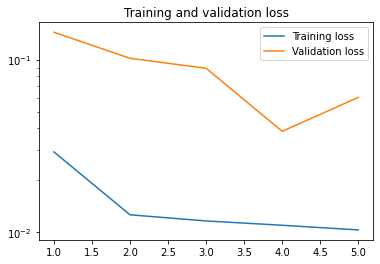

In [8]:
training("/content/gdrive/MyDrive/Train/spectrogram/", "/content/gdrive/MyDrive/Train/weights", "unet", True, 5, 20)

In [33]:
def prediction(weights_path, name_model, audio_dir_prediction, dir_save_prediction, audio_input_prediction,
audio_output_prediction, sample_rate, min_duration, frame_length, hop_length_frame, n_fft, hop_length_fft):
    """ This function takes as input pretrained weights, noisy voice sound to denoise, predict
    the denoise sound and save it to disk.
    """
    print(audio_input_prediction)
    loaded_model = load_model("./demo_data/weights/model_unet.h5")

    # Extracting noise and voice from folder and convert to numpy
    audio = audio_files_to_numpy(audio_dir_prediction, [audio_input_prediction], sample_rate,
                                 frame_length, hop_length_frame, min_duration)

    print("A")
    #Dimensions of squared spectrogram
    dim_square_spec = int(n_fft / 2) + 1
    print(dim_square_spec)


    # Create Amplitude and phase of the sounds
    m_amp_db_audio,  m_pha_audio = numpy_audio_to_matrix_spectrogram(
        audio, dim_square_spec, n_fft, hop_length_fft)

    #global scaling to have distribution -1/1
    X_in = scaled_in(m_amp_db_audio)
    #Reshape for prediction
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    #Prediction using loaded network
    X_pred = loaded_model.predict(X_in)
    #Rescale back the noise model
    inv_sca_X_pred = inv_scaled_ou(X_pred)
    #Remove noise model from noisy speech
    X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]
    #Reconstruct audio from denoised spectrogram and phase
    print(X_denoise.shape)
    print(m_pha_audio.shape)
    print(frame_length)
    print(hop_length_fft)
    audio_denoise_recons = matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, frame_length, hop_length_fft)
    #Number of frames
    nb_samples = audio_denoise_recons.shape[0]
    #Save all frames in one file
    denoise_long = audio_denoise_recons.reshape(1, nb_samples * frame_length)*10
    librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], sample_rate)

In [34]:
# prediction(weights_path, name_model, audio_dir_prediction, dir_save_prediction, audio_input_prediction,
# audio_output_prediction, sample_rate, min_duration, frame_length, hop_length_frame, n_fft, hop_length_fft)

prediction("/content/gdrive/MyDrive/Train/weights", "model_unet", "./demo_data/test", "./demo_data/save_predictions/", "n1.wav", "n2.wav", 8000, 1.0, 8064, 8064, 255, 63)

n1.wav
['n1.wav']
A
128
(3, 128, 128)
(3, 128, 128)
8064
63


/usr/local/lib/python3.6/dist-packages/librosa/util/utils.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slices]
